In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 17110029.18it/s]


Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 68671028.24it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26615961.35it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 465521.31it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:35,  3.33it/s]


Epoch 1 of 100
Generator loss: 1.78959917, Discriminator loss: 0.78754354


118it [00:34,  3.38it/s]


Epoch 2 of 100
Generator loss: 4.00382568, Discriminator loss: 1.14572642


118it [00:37,  3.11it/s]


Epoch 3 of 100
Generator loss: 4.91585270, Discriminator loss: 0.39655764


118it [00:34,  3.41it/s]


Epoch 4 of 100
Generator loss: 2.72219847, Discriminator loss: 1.00336967


118it [00:36,  3.28it/s]


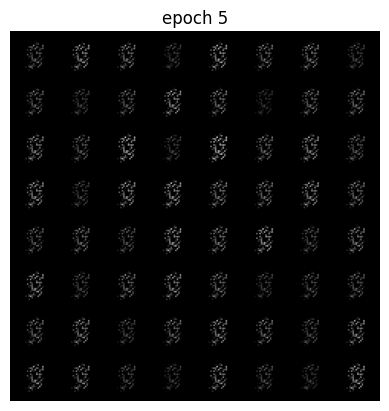

Epoch 5 of 100
Generator loss: 1.82876494, Discriminator loss: 0.97938496


118it [00:34,  3.41it/s]


Epoch 6 of 100
Generator loss: 2.06462576, Discriminator loss: 1.34129843


118it [00:35,  3.31it/s]


Epoch 7 of 100
Generator loss: 1.63728592, Discriminator loss: 1.02460700


118it [00:35,  3.33it/s]


Epoch 8 of 100
Generator loss: 1.80681468, Discriminator loss: 1.23997837


118it [00:34,  3.43it/s]


Epoch 9 of 100
Generator loss: 1.88139228, Discriminator loss: 1.13498069


118it [00:36,  3.27it/s]


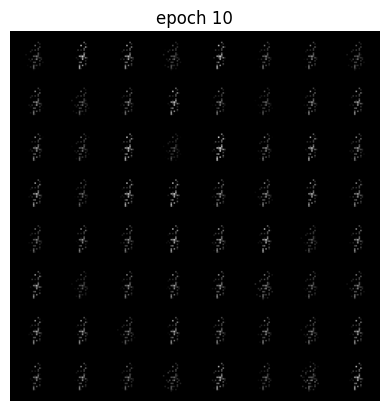

Epoch 10 of 100
Generator loss: 1.62520326, Discriminator loss: 1.13682651


118it [00:34,  3.38it/s]


Epoch 11 of 100
Generator loss: 1.51111356, Discriminator loss: 0.99863899


118it [00:35,  3.35it/s]


Epoch 12 of 100
Generator loss: 1.74463117, Discriminator loss: 1.11824770


118it [00:35,  3.34it/s]


Epoch 13 of 100
Generator loss: 1.41275379, Discriminator loss: 1.25796468


118it [00:34,  3.42it/s]


Epoch 14 of 100
Generator loss: 1.63620433, Discriminator loss: 1.02587082


118it [00:36,  3.26it/s]


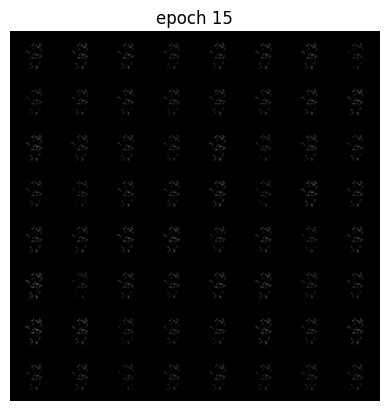

Epoch 15 of 100
Generator loss: 1.60452036, Discriminator loss: 1.08837775


118it [00:34,  3.43it/s]


Epoch 16 of 100
Generator loss: 1.63888040, Discriminator loss: 1.17110103


118it [00:34,  3.37it/s]


Epoch 17 of 100
Generator loss: 1.24826605, Discriminator loss: 1.28517886


118it [00:35,  3.33it/s]


Epoch 18 of 100
Generator loss: 1.61213337, Discriminator loss: 0.88767548


118it [00:34,  3.44it/s]


Epoch 19 of 100
Generator loss: 1.86689044, Discriminator loss: 1.21099661


118it [00:35,  3.30it/s]


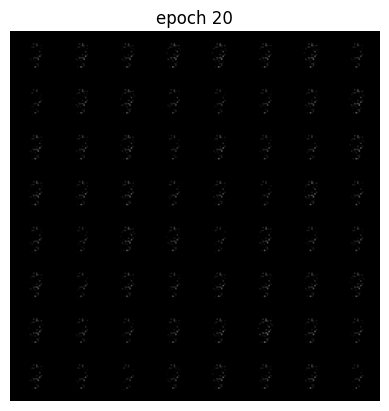

Epoch 20 of 100
Generator loss: 2.10106982, Discriminator loss: 0.82761507


118it [00:34,  3.44it/s]


Epoch 21 of 100
Generator loss: 1.56829804, Discriminator loss: 0.96942356


118it [00:34,  3.40it/s]


Epoch 22 of 100
Generator loss: 2.33545416, Discriminator loss: 0.54022507


118it [00:35,  3.31it/s]


Epoch 23 of 100
Generator loss: 3.09157673, Discriminator loss: 0.56220759


118it [00:34,  3.40it/s]


Epoch 24 of 100
Generator loss: 2.52489584, Discriminator loss: 0.85752760


118it [00:36,  3.24it/s]


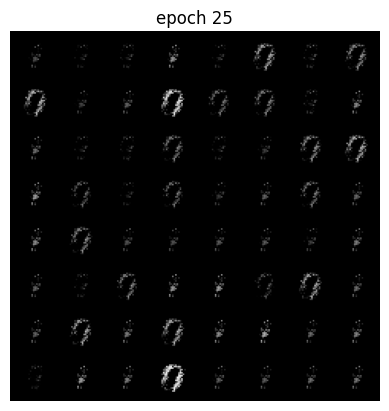

Epoch 25 of 100
Generator loss: 2.12204058, Discriminator loss: 0.65546277


118it [00:35,  3.37it/s]


Epoch 26 of 100
Generator loss: 1.85393008, Discriminator loss: 0.90853365


118it [00:35,  3.30it/s]


Epoch 27 of 100
Generator loss: 2.30358725, Discriminator loss: 0.61730266


118it [00:35,  3.29it/s]


Epoch 28 of 100
Generator loss: 2.70755049, Discriminator loss: 0.42543519


118it [00:35,  3.32it/s]


Epoch 29 of 100
Generator loss: 3.10464399, Discriminator loss: 0.43233963


118it [00:36,  3.23it/s]


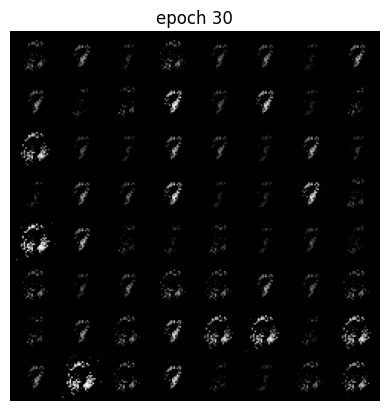

Epoch 30 of 100
Generator loss: 2.51169635, Discriminator loss: 0.69357823


118it [00:35,  3.37it/s]


Epoch 31 of 100
Generator loss: 2.45483321, Discriminator loss: 0.52403272


118it [00:36,  3.22it/s]


Epoch 32 of 100
Generator loss: 2.57807829, Discriminator loss: 0.61061991


118it [00:34,  3.38it/s]


Epoch 33 of 100
Generator loss: 2.59977096, Discriminator loss: 0.60131823


118it [00:35,  3.30it/s]


Epoch 34 of 100
Generator loss: 2.49545725, Discriminator loss: 0.63696086


118it [00:35,  3.29it/s]


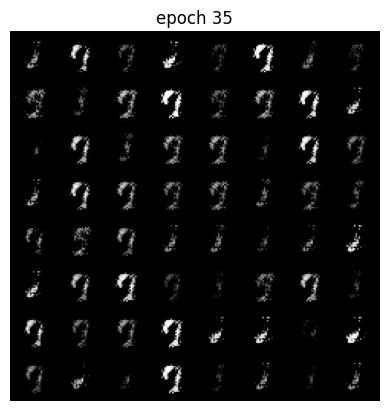

Epoch 35 of 100
Generator loss: 2.80380914, Discriminator loss: 0.55896619


118it [00:36,  3.23it/s]


Epoch 36 of 100
Generator loss: 2.05732087, Discriminator loss: 0.78410705


118it [00:37,  3.18it/s]


Epoch 37 of 100
Generator loss: 1.96303061, Discriminator loss: 0.69077532


118it [00:36,  3.27it/s]


Epoch 38 of 100
Generator loss: 2.64765518, Discriminator loss: 0.45019798


118it [00:37,  3.16it/s]


Epoch 39 of 100
Generator loss: 2.61219164, Discriminator loss: 0.52323809


118it [00:35,  3.29it/s]


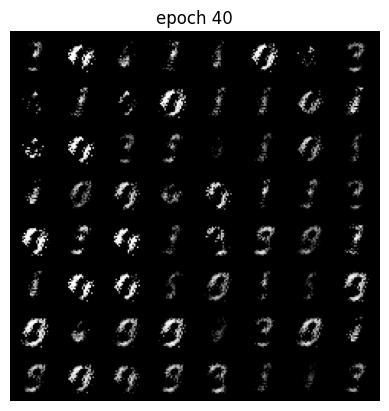

Epoch 40 of 100
Generator loss: 2.83756165, Discriminator loss: 0.51784705


118it [00:37,  3.14it/s]


Epoch 41 of 100
Generator loss: 2.27079850, Discriminator loss: 0.74717952


118it [00:35,  3.29it/s]


Epoch 42 of 100
Generator loss: 2.05855543, Discriminator loss: 0.66753326


118it [00:37,  3.16it/s]


Epoch 43 of 100
Generator loss: 2.44102565, Discriminator loss: 0.54245940


118it [00:35,  3.30it/s]


Epoch 44 of 100
Generator loss: 2.26905710, Discriminator loss: 0.70328185


118it [00:37,  3.17it/s]


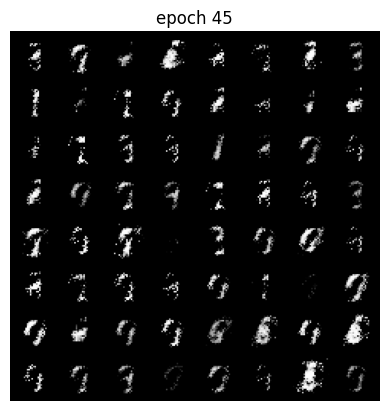

Epoch 45 of 100
Generator loss: 2.05969252, Discriminator loss: 0.76825485


118it [00:35,  3.31it/s]


Epoch 46 of 100
Generator loss: 1.90108559, Discriminator loss: 0.72898296


118it [00:37,  3.16it/s]


Epoch 47 of 100
Generator loss: 2.40564278, Discriminator loss: 0.56847503


118it [00:36,  3.27it/s]


Epoch 48 of 100
Generator loss: 2.46521634, Discriminator loss: 0.62119178


118it [00:37,  3.17it/s]


Epoch 49 of 100
Generator loss: 2.20431550, Discriminator loss: 0.67654799


118it [00:35,  3.31it/s]


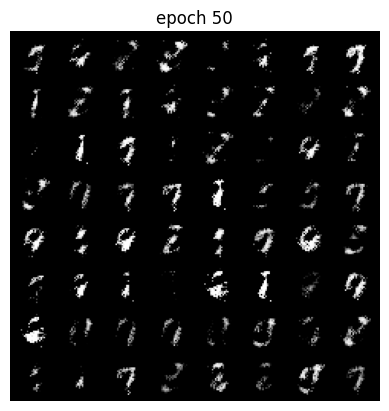

Epoch 50 of 100
Generator loss: 1.98506911, Discriminator loss: 0.80996288


118it [00:39,  3.00it/s]


Epoch 51 of 100
Generator loss: 1.94294372, Discriminator loss: 0.74938958


118it [00:35,  3.33it/s]


Epoch 52 of 100
Generator loss: 1.84877192, Discriminator loss: 0.79426883


118it [00:37,  3.17it/s]


Epoch 53 of 100
Generator loss: 1.63794949, Discriminator loss: 0.89650417


118it [00:35,  3.37it/s]


Epoch 54 of 100
Generator loss: 1.91959438, Discriminator loss: 0.73655169


118it [00:35,  3.28it/s]


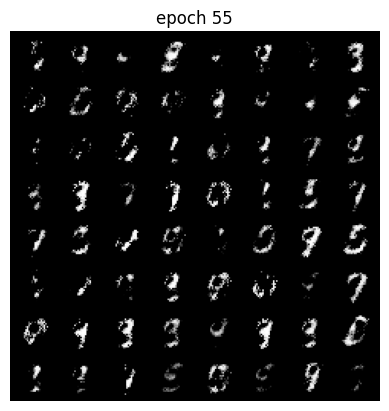

Epoch 55 of 100
Generator loss: 2.23511941, Discriminator loss: 0.67616442


118it [00:36,  3.24it/s]


Epoch 56 of 100
Generator loss: 2.16287250, Discriminator loss: 0.66122348


118it [00:36,  3.21it/s]


Epoch 57 of 100
Generator loss: 1.93390692, Discriminator loss: 0.75159570


118it [00:36,  3.22it/s]


Epoch 58 of 100
Generator loss: 1.93725295, Discriminator loss: 0.77213360


118it [00:35,  3.31it/s]


Epoch 59 of 100
Generator loss: 1.65230082, Discriminator loss: 0.92851831


118it [00:36,  3.20it/s]


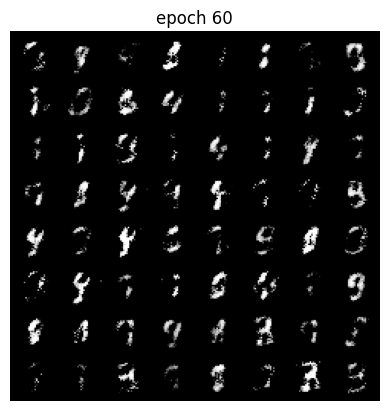

Epoch 60 of 100
Generator loss: 1.56453716, Discriminator loss: 0.91583049


118it [00:35,  3.32it/s]


Epoch 61 of 100
Generator loss: 1.90937490, Discriminator loss: 0.77983924


118it [00:37,  3.16it/s]


Epoch 62 of 100
Generator loss: 2.12408840, Discriminator loss: 0.72212876


118it [00:35,  3.31it/s]


Epoch 63 of 100
Generator loss: 2.13844406, Discriminator loss: 0.77836624


118it [00:37,  3.19it/s]


Epoch 64 of 100
Generator loss: 2.14442616, Discriminator loss: 0.78385228


118it [00:35,  3.35it/s]


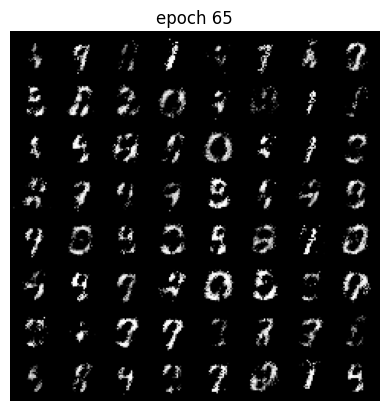

Epoch 65 of 100
Generator loss: 1.93523087, Discriminator loss: 0.81511772


118it [00:36,  3.27it/s]


Epoch 66 of 100
Generator loss: 2.12855363, Discriminator loss: 0.73663582


118it [00:35,  3.28it/s]


Epoch 67 of 100
Generator loss: 1.93060567, Discriminator loss: 0.80233409


118it [00:35,  3.35it/s]


Epoch 68 of 100
Generator loss: 2.11861180, Discriminator loss: 0.75818566


118it [00:36,  3.22it/s]


Epoch 69 of 100
Generator loss: 2.09123939, Discriminator loss: 0.74473292


118it [00:35,  3.36it/s]


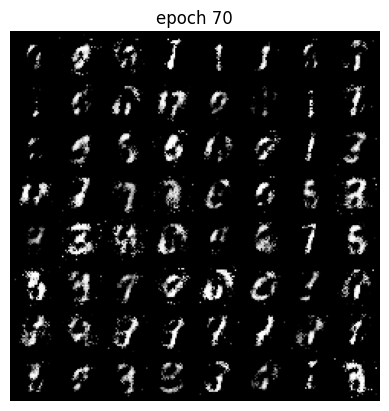

Epoch 70 of 100
Generator loss: 2.20423346, Discriminator loss: 0.67578081


118it [00:36,  3.22it/s]


Epoch 71 of 100
Generator loss: 2.10768282, Discriminator loss: 0.76341450


118it [00:35,  3.34it/s]


Epoch 72 of 100
Generator loss: 1.99601464, Discriminator loss: 0.80233660


118it [00:35,  3.28it/s]


Epoch 73 of 100
Generator loss: 1.74361707, Discriminator loss: 0.85802070


118it [00:35,  3.29it/s]


Epoch 74 of 100
Generator loss: 1.65517411, Discriminator loss: 0.90201546


118it [00:34,  3.44it/s]


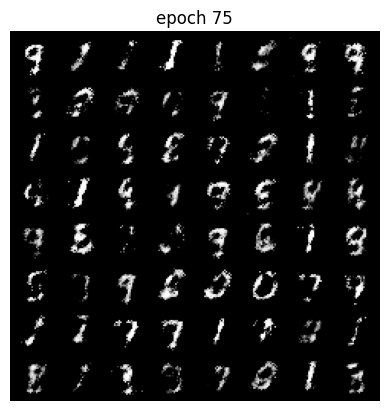

Epoch 75 of 100
Generator loss: 1.90575220, Discriminator loss: 0.79003323


118it [00:36,  3.26it/s]


Epoch 76 of 100
Generator loss: 2.02839831, Discriminator loss: 0.75971916


118it [00:34,  3.39it/s]


Epoch 77 of 100
Generator loss: 2.02530969, Discriminator loss: 0.79149829


118it [00:35,  3.32it/s]


Epoch 78 of 100
Generator loss: 2.00829462, Discriminator loss: 0.78305060


118it [00:35,  3.33it/s]


Epoch 79 of 100
Generator loss: 2.04813806, Discriminator loss: 0.71654712


118it [00:34,  3.38it/s]


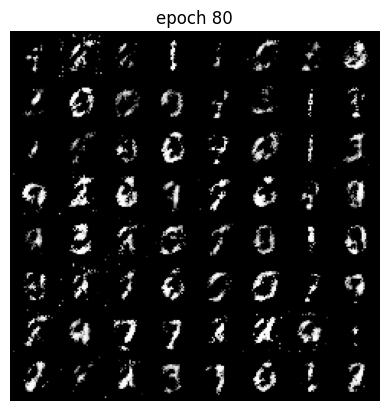

Epoch 80 of 100
Generator loss: 2.10376994, Discriminator loss: 0.75724343


118it [00:36,  3.23it/s]


Epoch 81 of 100
Generator loss: 2.09932640, Discriminator loss: 0.73385430


118it [00:34,  3.41it/s]


Epoch 82 of 100
Generator loss: 2.18419921, Discriminator loss: 0.76004418


118it [00:34,  3.38it/s]


Epoch 83 of 100
Generator loss: 1.96783432, Discriminator loss: 0.77522219


118it [00:36,  3.27it/s]


Epoch 84 of 100
Generator loss: 1.95020182, Discriminator loss: 0.75710268


118it [00:35,  3.36it/s]


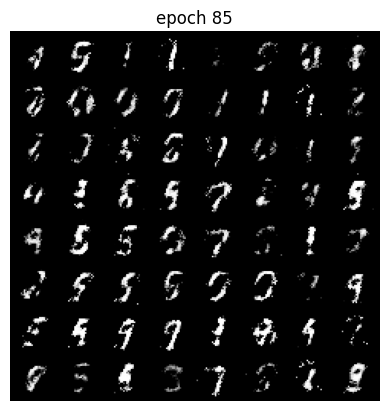

Epoch 85 of 100
Generator loss: 2.07978850, Discriminator loss: 0.82308184


118it [00:36,  3.19it/s]


Epoch 86 of 100
Generator loss: 1.87846379, Discriminator loss: 0.81756160


118it [00:35,  3.31it/s]


Epoch 87 of 100
Generator loss: 1.80585406, Discriminator loss: 0.78557723


118it [00:36,  3.23it/s]


Epoch 88 of 100
Generator loss: 2.02931490, Discriminator loss: 0.70426857


118it [00:36,  3.27it/s]


Epoch 89 of 100
Generator loss: 2.07601964, Discriminator loss: 0.72245484


118it [00:35,  3.34it/s]


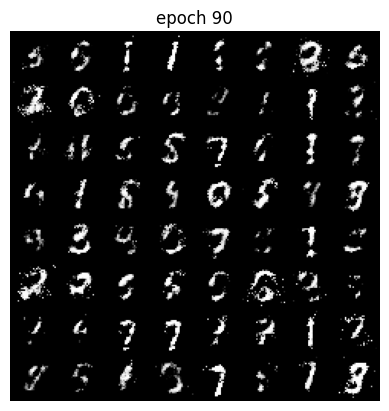

Epoch 90 of 100
Generator loss: 2.06355590, Discriminator loss: 0.75627214


118it [00:36,  3.22it/s]


Epoch 91 of 100
Generator loss: 1.97576828, Discriminator loss: 0.85770621


118it [00:35,  3.33it/s]


Epoch 92 of 100
Generator loss: 1.87772199, Discriminator loss: 0.89016065


118it [00:36,  3.20it/s]


Epoch 93 of 100
Generator loss: 1.74921509, Discriminator loss: 0.84805989


118it [00:35,  3.33it/s]


Epoch 94 of 100
Generator loss: 1.96174419, Discriminator loss: 0.81282730


118it [00:35,  3.28it/s]


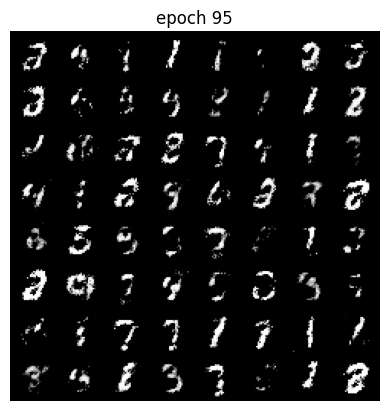

Epoch 95 of 100
Generator loss: 1.98039004, Discriminator loss: 0.82277382


118it [00:36,  3.27it/s]


Epoch 96 of 100
Generator loss: 1.76626715, Discriminator loss: 0.85808886


118it [00:36,  3.27it/s]


Epoch 97 of 100
Generator loss: 1.64790805, Discriminator loss: 0.91508878


118it [00:37,  3.15it/s]


Epoch 98 of 100
Generator loss: 1.66747425, Discriminator loss: 0.88646289


118it [00:36,  3.28it/s]


Epoch 99 of 100
Generator loss: 1.79155820, Discriminator loss: 0.82272157


118it [00:37,  3.16it/s]


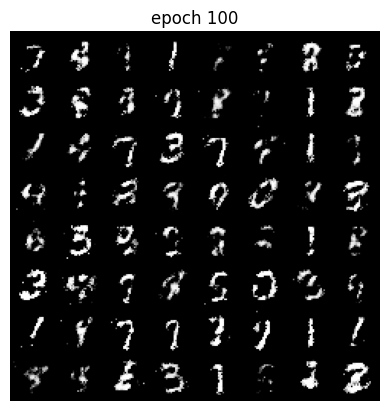

Epoch 100 of 100
Generator loss: 1.85062525, Discriminator loss: 0.80570054


In [14]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########

    return criterion(output,true_label)

    ######################################

def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########

    return criterion(output,true_label)


    ######################################


for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ##########

        #Discriminator
        real_img = data[0].to(device)
        real_labels = label_real(real_img.shape[0])

        for _ in range(k):
          optim_d.zero_grad()
          real_output_d = discriminator(real_img)
          real_loss_d = discriminator_loss(real_output_d,real_labels)

          fake_imgs = generator(create_noise(sample_size,nz)).detach()
          fake_labels = label_fake(sample_size)
          fake_output_d = discriminator(fake_imgs)
          fake_loss_d = discriminator_loss(fake_output_d, fake_labels)

          real_loss_d.backward()
          fake_loss_d.backward()
          loss_dis= real_loss_d + fake_loss_d
          optim_d.step()
          loss_d += loss_dis.item()

        #Generator
        optim_g.zero_grad()
        real_labels = label_real(sample_size)
        fake_imgs = generator(create_noise(sample_size,nz))
        output_d = discriminator(fake_imgs)
        loss_gen = generator_loss(output_d, real_labels)
        loss_gen.backward()
        optim_g.step()
        loss_g += loss_gen.item()

        ######################################


    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [15]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [16]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

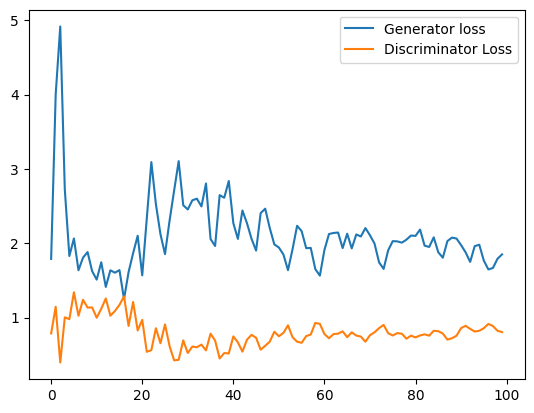

In [17]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')